# COMPAS analysis

We recreate the first section of the [Propublica COMPAS analysis](https://github.com/propublica/compas-analysis) in Python. 

What follows are the calculations performed for ProPublica's analaysis of the COMPAS Recidivism Risk Scores. It might be helpful to open [the methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/) in another tab to understand the following.



## Loading the Data

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.



In [ ]:
# Charles Tang

import pandas as pd
import datetime

In [3]:
raw_data = pd.read_csv('./compas-scores-two-years.csv')
print('Num rows: %d' %len(raw_data))

Num rows: 7214


However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:

 - If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
 - We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
 - In a similar vein, ordinary traffic offenses -- those with a df of 'O' -- will not result in Jail time are removed (only two of them).
 - We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
 - We remove rows where there is no score_text ('N/A')

In [4]:
# TODO: implement the filtering explained above
# Hint: you should end up with 6172
df = raw_data[(raw_data['days_b_screening_arrest'] <= 30) & (raw_data['days_b_screening_arrest'] >= -30) & (raw_data['is_recid'] != -1) & (raw_data['c_charge_degree'] != 'O') & (raw_data['score_text'] != 'N/A')]

In [5]:
print('Num rows filtered: %d' % len(df))

Num rows filtered: 6172


In [6]:
raw_data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


Higher COMPAS scores are slightly correlated with a longer length of stay.



In [7]:
import numpy as np
from datetime import datetime
from scipy.stats import pearsonr

In [8]:
def date_from_str(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

In [9]:
# TODO: find the Pearson correlation between length of stay (jail_out - jail_in) and COMPAS decile
r = pearsonr(df['decile_score'], (df['c_jail_out'].apply(date_from_str) - df['c_jail_in'].apply(date_from_str)).apply(lambda x: x.days))
print('Pearson correlation: %f' % r[0])

Pearson correlation: 0.207478


After filtering we have the following demographic breakdown:

In [10]:
# TODO: find counts for each age group
df['age_cat'].value_counts()

age_cat
25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: count, dtype: int64

In [11]:

# TODO: find counts and percentages for each race group
df['race'].value_counts()

race
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: count, dtype: int64

In [12]:
# TODO: find counts of each score_text group
df.score_text.value_counts()

score_text
Low       3421
Medium    1607
High      1144
Name: count, dtype: int64

In [13]:
# TODO: create interaction table of counts between race/sex interactions
pd.crosstab(df['sex'], df['race'])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


In [14]:
# TODO: find counts and percentages for each gender group
df["sex"].value_counts()

sex
Male      4997
Female    1175
Name: count, dtype: int64

In [15]:
# TODO: How many defendants had two-year recidivism in last two years? What percentage of all defendants
df[df['two_year_recid'] == 1].shape[0]

2809

Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.



In [16]:
%matplotlib inline

from matplotlib import pyplot as plt

Text(0, 0.5, 'Count')

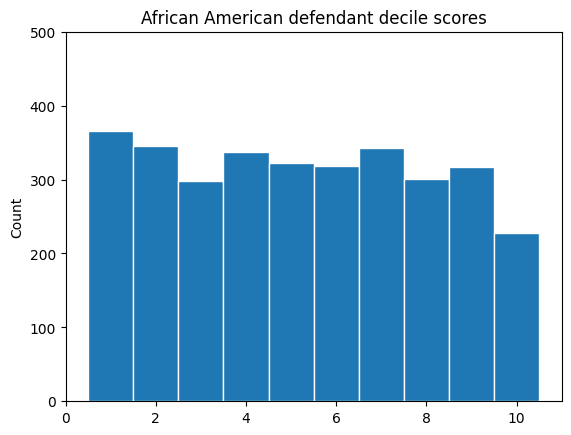

In [17]:
# TODO: plot decile scores by count for African-America defendants
black_df = df[df['race'] == 'African-American']
black_df['decile_score'].hist(edgecolor="white", grid=False, bins=np.arange(13)-0.5)
plt.ylim([0,500])
plt.xlim([0,11])
plt.title('African American defendant decile scores')
plt.ylabel('Count')

Text(0.5, 0, 'Score decile')

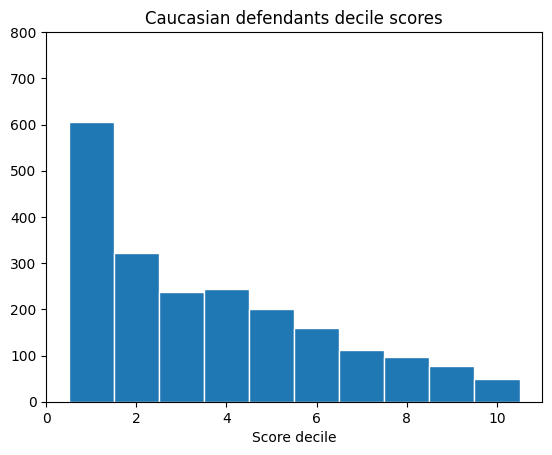

In [18]:
# TODO: plot decile scores by count for Caucasian defendants
caucasian_df = df[df['race'] == 'Caucasian']
caucasian_df['decile_score'].hist(bins=np.arange(13)-0.5,grid=False, edgecolor="white")
plt.ylim([0,800])
plt.xlim([0,11])
plt.title('Caucasian defendants decile scores')
plt.xlabel('Score decile')

In [19]:
# TODO: Create a pivot table between decile_score and race
pd.crosstab(df.decile_score, df.race)

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


## Racial Bias in Compas

After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.


In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
lr = LogisticRegression(solver='lbfgs')

In [32]:
# TODO: create columns for all options for charge_degree, age, race, sex, and 
df_crime = pd.get_dummies(df['c_charge_degree'], drop_first=True)
df_age = pd.get_dummies(df['age_cat'])
df_race = pd.get_dummies(df['race'])
df_gender = pd.get_dummies(df['sex'], drop_first=True)
df_score = pd.get_dummies(df['score_text'] != 'Low', drop_first=True)
df_prior = df['priors_count']
df_two_year = df['two_year_recid']

In [33]:
data = pd.concat([df_crime, df_age,df_race,df_gender, df_prior, df_two_year],axis=1)

In [34]:
data

,M,25 - 45,Greater than 45,Less than 25,African-American,Asian,Caucasian,Hispanic,Native American,Other,Male,priors_count,two_year_recid
0,False,False,True,False,False,False,False,False,False,True,True,0,0
1,False,True,False,False,True,False,False,False,False,False,True,0,1
2,False,False,False,True,True,False,False,False,False,False,True,4,1
5,True,True,False,False,False,False,False,False,False,True,True,0,0
6,False,True,False,False,False,False,True,False,False,False,True,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,False,False,False,True,True,False,False,False,False,False,True,0,0
7210,False,False,False,True,True,False,False,False,False,False,True,0,0
7211,False,False,True,False,False,False,False,False,False,True,True,0,0
7212,True,True,False,False,True,False,False,False,False,False,False,3,0


In [35]:
df_score

,True
0,False
1,False
2,False
5,False
6,True
...,...
7209,True
7210,False
7211,False
7212,False


In [36]:
# TODO: Run these input features to predict whether score_text is Low or Med/High using a Logistic Regression
lr.fit(data,df_score.values.ravel())

LogisticRegression()

In [37]:
# TODO: What is the correlation coefficient for African_American? What is the odds ratio?
cols = np.concatenate([df_crime.columns.values, 
                df_age.columns.values,
                df_race.columns.values,
                df_gender.columns.values,
                ['priors_count'], 
                ['two_year_recid']])

In [38]:
for i,j in zip(cols, lr.coef_[0]): 
    print(round(j, 2), i)

-0.31 M
-0.21 25 - 45
-1.56 Greater than 45
1.09 Less than 25
0.39 African-American
-0.36 Asian
-0.08 Caucasian
-0.51 Hispanic
0.79 Native American
-0.9 Other
-0.22 Male
0.27 priors_count
0.68 two_year_recid


## Calculate Odds Ratios

In [39]:
cols_list = list(cols)

race_black_idx = cols_list.index('African-American')
race_white_idx = cols_list.index('Caucasian')

delta_logit = lr.coef_[0][race_black_idx] - lr.coef_[0][race_white_idx]
odds_ratio = np.exp(delta_logit)
print('Odds ratio: %f' % odds_ratio)

Odds ratio: 1.611223


In [44]:
cols_list

['M',
 '25 - 45',
 'Greater than 45',
 'Less than 25',
 'African-American',
 'Asian',
 'Caucasian',
 'Hispanic',
 'Native American',
 'Other',
 'Male',
 'priors_count',
 'two_year_recid']

In [ ]:
import numpy as np
def logistic(x):
    return 1 / (1 + np.exp(-x))

baseline = np.zeros(len(cols))
x_white = baseline.copy()
cols_list = list(cols)
race_white_idx = cols_list.index('Caucasian')
x_white[race_white_idx] = 1

x_black = baseline.copy()
race_black_idx = cols_list.index('African-American')
x_black[race_black_idx] = 1

logit_white = lr.intercept_[0] + np.dot(lr.coef_, x_white)
logit_black = lr.intercept_[0] + np.dot(lr.coef_, x_black)

prob_white = logistic(logit_white)
prob_black = logistic(logit_black)

# odds ratios
odds_white = prob_white / (1 - prob_white)
odds_black = prob_black / (1 - prob_black)
odds = odds_black / odds_white

print('Prob white: %.4f' % prob_white)
print('Prob black: %.4f' % prob_black)
print('Odds white: %.4f' % odds)

Prob white: 0.2502
Prob black: 0.3497
Odds white: 1.6112


/var/folders/0l/p7x7d7755vq4wc8qty73kcy40000gn/T/ipykernel_4172/2601001575.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Prob white: %.4f' % prob_white)
/var/folders/0l/p7x7d7755vq4wc8qty73kcy40000gn/T/ipykernel_4172/2601001575.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Prob black: %.4f' % prob_black)
/var/folders/0l/p7x7d7755vq4wc8qty73kcy40000gn/T/ipykernel_4172/2601001575.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('